## Animal Classification Using InceptionV3

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import random
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

c:\Users\User\anaconda3\envs\py39\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


## Data Understanding and Preprocessing

In [16]:
def rename_subfolders(image_dir, translation_dict):
    subfolders = os.listdir(image_dir)
    
    # Clean the subfolder name and rename the name if the subfolder names are different
    for subfolder in subfolders:
        subfolder_cleaned = subfolder.strip().lower()  
        new_name = translation_dict.get(subfolder_cleaned, subfolder_cleaned) 
        
        old_path = os.path.join(image_dir, subfolder)
        new_path = os.path.join(image_dir, new_name)
        
        if old_path != new_path:
            os.rename(old_path, new_path)
            print(f"Renamed '{subfolder}' to '{new_name}'")

image_dir = 'C:\\Users\\User\\Desktop\\Tensorflow\\Animal_Classification\\raw-img'
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", 
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", 
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", 
    "ragno": "spider","dog": "cane", "horse": "cavallo", 
    "elephant": "elefante", "butterfly": "farfalla", "chicken": "gallina", 
    "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"
}

rename_subfolders(image_dir, translate)

Renamed 'cane' to 'dog'
Renamed 'cavallo' to 'horse'
Renamed 'elefante' to 'elephant'
Renamed 'farfalla' to 'butterfly'
Renamed 'gallina' to 'chicken'
Renamed 'gatto' to 'cat'
Renamed 'mucca' to 'cow'
Renamed 'ragno' to 'spider'
Renamed 'scoiattolo' to 'squirrel'


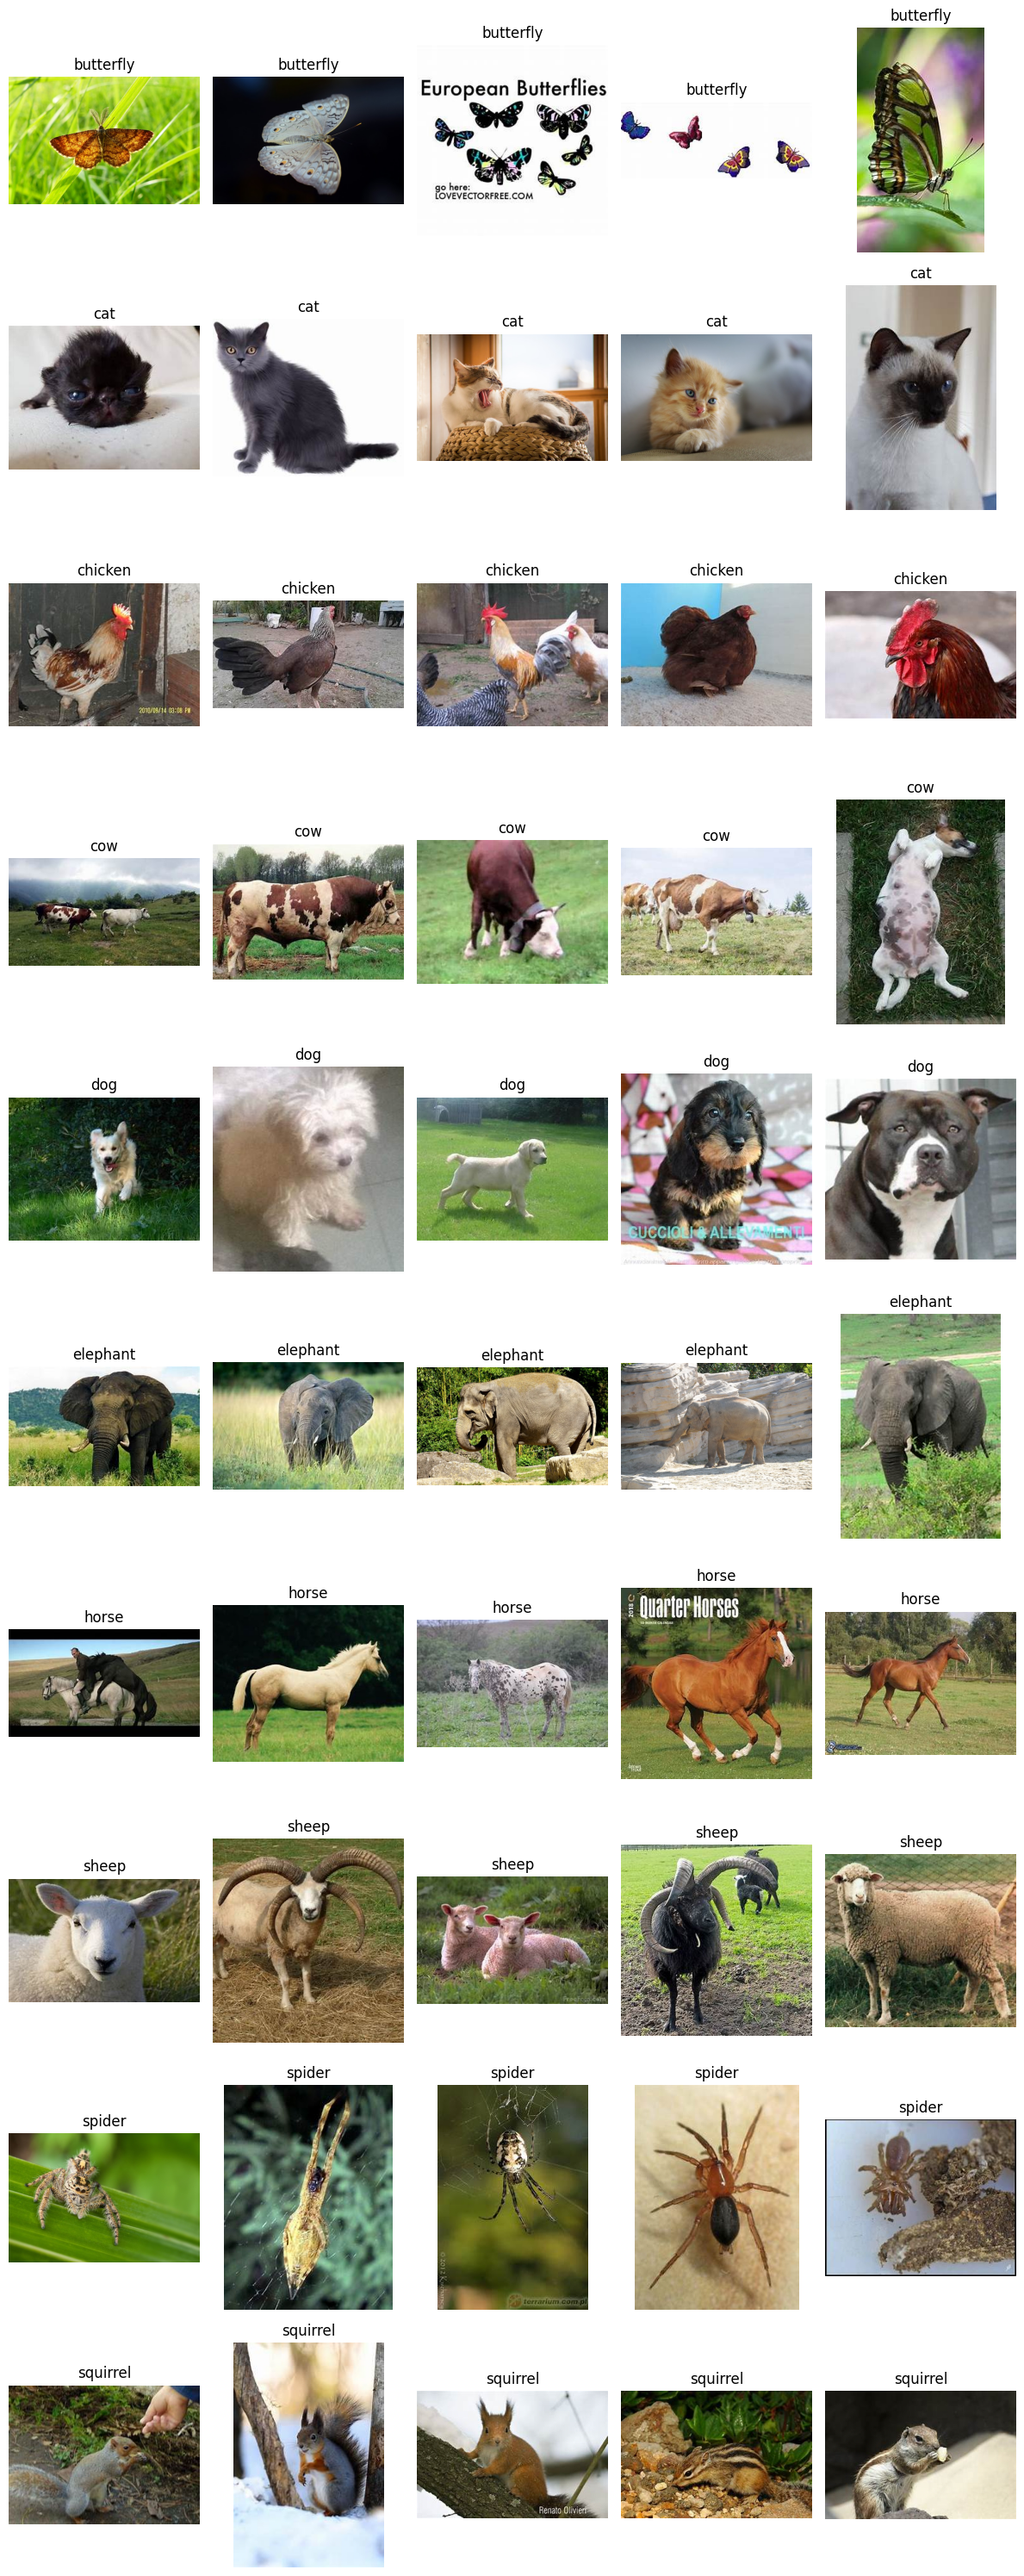

In [17]:
# Plot each catagory with 5 example images
def plot_raw_image(image_dir, num_samples=5):
    classes = os.listdir(image_dir)
    plt.figure(figsize=(12, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        class_dir = os.path.join(image_dir, cls)
        images = os.listdir(class_dir)
        sample_image = random.sample(images, min(num_samples, len(images)))
        
        for j, img_file in enumerate(sample_image):
            img_path = os.path.join(class_dir, img_file)
            img = Image.open(img_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
image_dir = 'C:\\Users\\User\\Desktop\\Tensorflow\\Animal_Classification\\raw-img'
plot_raw_image(image_dir, num_samples=5)

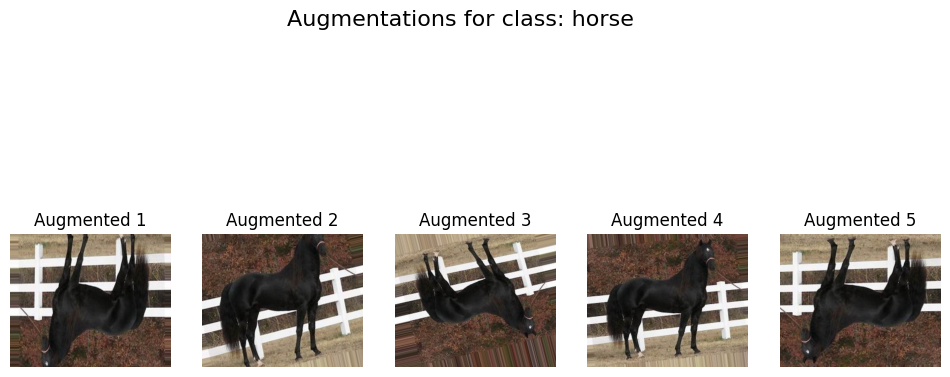

In [19]:
# Demonstrate the augmentation to make sure it is working as expected
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
)

def visualize_augmentations(image_dir, num_samples=5):
    classes = os.listdir(image_dir)
    selected_class = random.choice(classes)
    class_dir = os.path.join(image_dir, selected_class)
    
    images = os.listdir(class_dir)
    selected_image = random.choice(images)
    image_path = os.path.join(class_dir, selected_image)
    
    img = Image.open(image_path)
    img_array = np.array(img).reshape((1,) + np.array(img).shape)

    augmented_images = [next(train_datagen.flow(img_array))[0].astype('uint8') for _ in range(num_samples)]
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Augmentations for class: {selected_class}", fontsize=16)
    for i, aug_img in enumerate(augmented_images):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(aug_img)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    plt.show()

image_dir = 'C:\\Users\\User\\Desktop\\Tensorflow\\Animal_Classification\\raw-img'
visualize_augmentations(image_dir, num_samples=5)

In [20]:
# Define the size which the InceptionV3 model desired
image_height = 299
image_width = 299
batch_size = 64

In [21]:
# Image Augmentation for train and test set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

# Define train and test data for training
train_gen = train_datagen.flow_from_directory(
    'raw-img/',
    target_size=(image_height, image_width),
    batch_size= batch_size,
    color_mode = 'rgb',
    class_mode='sparse',
    shuffle = True,
    seed =123,
)

validation_gen = validation_datagen.flow_from_directory(
    'raw-img/',
    target_size=(image_height, image_width),
    batch_size= batch_size,
    color_mode = 'rgb',
    class_mode='sparse',
    shuffle = True,
    seed =123,
)

Found 26179 images belonging to 10 classes.
Found 26179 images belonging to 10 classes.


In [22]:
# Calculation for the classes and get the summary info for the train set
def get_generator_info(train_gen):
    # Number of classes
    num_classes = len(train_gen.class_indices)
    class_counts = train_gen.class_indices
    
    print(f"Number of classes: {num_classes}")
    print(f"Class distribution: {class_counts}")

    # Get a batch of data from the generator
    batch = next(train_gen)
    images, labels = batch

    # Image information from the first image in the batch
    img_shape = images[0].shape
    print(f"Image dimensions: {img_shape[1:]}")
    print(f"Image data type: {images[0].dtype}")
    print(f"Number of images in a batch: {images.shape[0]}")

get_generator_info(train_gen)

Number of classes: 10
Class distribution: {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
Image dimensions: (299, 3)
Image data type: float32
Number of images in a batch: 64


In [23]:
num_classes = 10

## Model Building and Training

In [24]:
# Load InceptionV3 with pre-trained weights from ImageNet
# Use Functional to connect with defined fully connected layers
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation ='relu')(x)
x = layers.Dense(10)(x)

model = tf.keras.models.Model(inputs = base_model.input, outputs = x)

# Freeze the pre-trained weights of InceptionV3
for layer in base_model.layers:
    layer.trainable = False

In [26]:
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy'],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   9216        ['activation[0][0]']             
                                32)                                                               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, None, None,   96         ['conv2d_1[0][0]']               
 rmalization)                   32)                                                               
                                                                                                  
 activation_1 (Activation)      (None, None, None,   0           ['batch_normalization_1[0][0]']  
                                32)                                                               
          

In [27]:
history = model.fit(
    train_gen,
    epochs=5,
    steps_per_epoch = train_gen.samples // batch_size,
    validation_data = validation_gen,
    validation_steps = validation_gen.samples // batch_size,
)

Epoch 1/5
409/409 [==============================] - 693s 2s/step - loss: 0.4127 - accuracy: 0.8770 - val_loss: 0.1130 - val_accuracy: 0.9689
Epoch 2/5
409/409 [==============================] - 783s 2s/step - loss: 0.2709 - accuracy: 0.9135 - val_loss: 0.0953 - val_accuracy: 0.9732
Epoch 3/5
409/409 [==============================] - 724s 2s/step - loss: 0.2526 - accuracy: 0.9179 - val_loss: 0.0912 - val_accuracy: 0.9728
Epoch 4/5
409/409 [==============================] - 698s 2s/step - loss: 0.2319 - accuracy: 0.9239 - val_loss: 0.0832 - val_accuracy: 0.9755
Epoch 5/5
409/409 [==============================] - 706s 2s/step - loss: 0.2196 - accuracy: 0.9271 - val_loss: 0.0811 - val_accuracy: 0.9765


## Model Evaluation

In [28]:
score = model.evaluate(
    validation_gen,
    steps=validation_gen.samples // batch_size
)

409/409 [==============================] - 145s 354ms/step - loss: 0.0811 - accuracy: 0.9765


In [13]:
model.save("InceptionV3_Animal.h5")

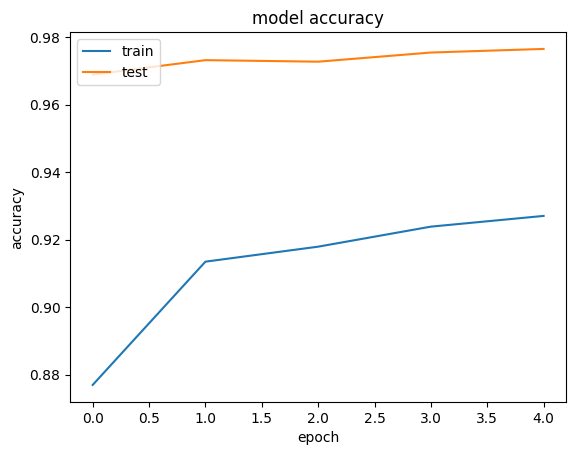

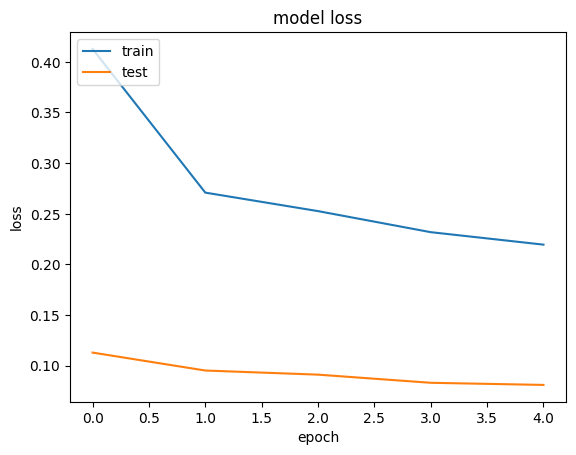

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Found 26179 images belonging to 10 classes.
410/410 [==============================] - 139s 339ms/step
Classification Report:

              precision    recall  f1-score   support

   butterfly       0.99      0.98      0.99      2112
         cat       0.97      0.99      0.98      1668
     chicken       0.99      0.99      0.99      3098
         cow       0.89      0.97      0.93      1866
         dog       0.98      0.98      0.98      4863
    elephant       0.99      0.97      0.98      1446
       horse       0.97      0.96      0.97      2623
       sheep       0.97      0.91      0.94      1820
      spider       0.99      0.99      0.99      4821
    squirrel       0.97      0.99      0.98      1862

    accuracy                           0.98     26179
   macro avg       0.97      0.97      0.97     26179
weighted avg       0.98      0.98      0.98     26179



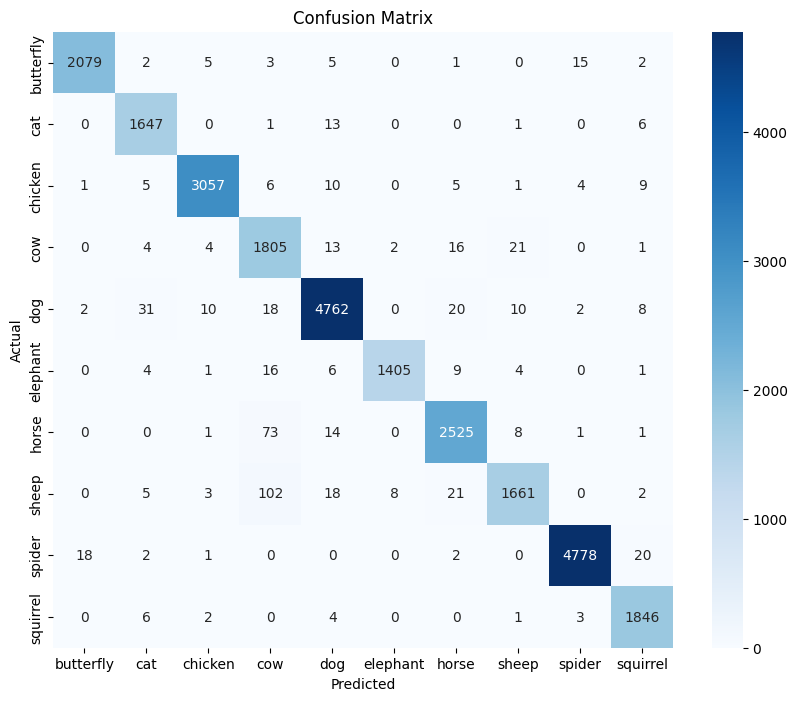

In [32]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Define the validation set into no shuffle to avoid causing wrong labelling in confusion matrix
validation_gen = validation_datagen.flow_from_directory(
    'raw-img/',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=False,
    seed=123,
)

predictions = model.predict(validation_gen, verbose=1)

predicted_class_indices = np.argmax(predictions, axis=1)

true_class_indices = validation_gen.classes

class_labels = list(validation_gen.class_indices.keys())

# Generate the classification report and confusion matrix
print("Classification Report:\n")
report = classification_report(true_class_indices, predicted_class_indices, target_names=class_labels)
print(report)

conf_matrix = confusion_matrix(true_class_indices, predicted_class_indices)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()